In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Input, Dense
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
import os

# Sending all images in the sent folder and its subfolders to pad and resize
def pre_process_per_dir(dir_path):
    for subdir, dirs, files in os.walk(dir_path):
        for file in files:
            pre_process_per_image2(os.path.join(subdir, file))

# pading image to make it square            
def pad_image(img):
  img_H,img_W = img.shape[:2]
  top = bottom = left = right = 0
  if img_H == img_W:
    return img
  if img_H < img_W:
    top = bottom = (img_W-img_H)//2
  else:
    left = right = (img_H-img_W)//2
  return cv2.copyMakeBorder(img,top,bottom,left,right,cv2.BORDER_CONSTANT,value=[0, 0, 0])

# pad and resize
def pre_process_per_image1(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = pad_image(img)
  if img.shape[0] > 64:
    img = cv2.resize(img,(64,64))
  img = cv2.resize(img,(40,40))
  cv2.imwrite(img_path,img)

def resize(image, width=None, height=None):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim,interpolation =  cv2.INTER_AREA)
    return resized

def pre_process_per_image2(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  (tH, tW) = img.shape
  if tW > tH:
    img = resize(img, width=40)
  else:
    img = resize(img, height=40)
  (tH, tW) = img.shape 
  dX = int(max(0, 40 - tW) / 2.0)
  dY = int(max(0, 40 - tH) / 2.0)
  padded = cv2.copyMakeBorder(img, top=dY, bottom=dY,left=dX,
                              right=dX, borderType=cv2.BORDER_CONSTANT,value=(0, 0, 0))
  if padded.shape[0] + padded.shape[1] > 128:
    padded = cv2.resize(padded, (64, 64),interpolation = cv2.INTER_AREA)
  padded = cv2.resize(padded, (40, 40),interpolation =  cv2.INTER_AREA)
  cv2.imwrite(img_path,padded)

In [ ]:
import os
import zipfile
#unzip heb letter zip file to tmp directory
local_zip = '/content/drive/MyDrive/dataset_for_heb_letters 2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
base_dir = '/tmp/dataset_for_heb_letters'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [ ]:
for i in [train_dir,validation_dir]:
  pre_process_per_dir(i)

In [ ]:
import random
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = random.uniform(6.0, 20.0)
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    if random.random() > 0.5:
      img += noise
    else:
      img -= noise
    np.clip(img, 0., 255.)
    return img

Found 6898 images belonging to 27 classes.
Found 861 images belonging to 27 classes.


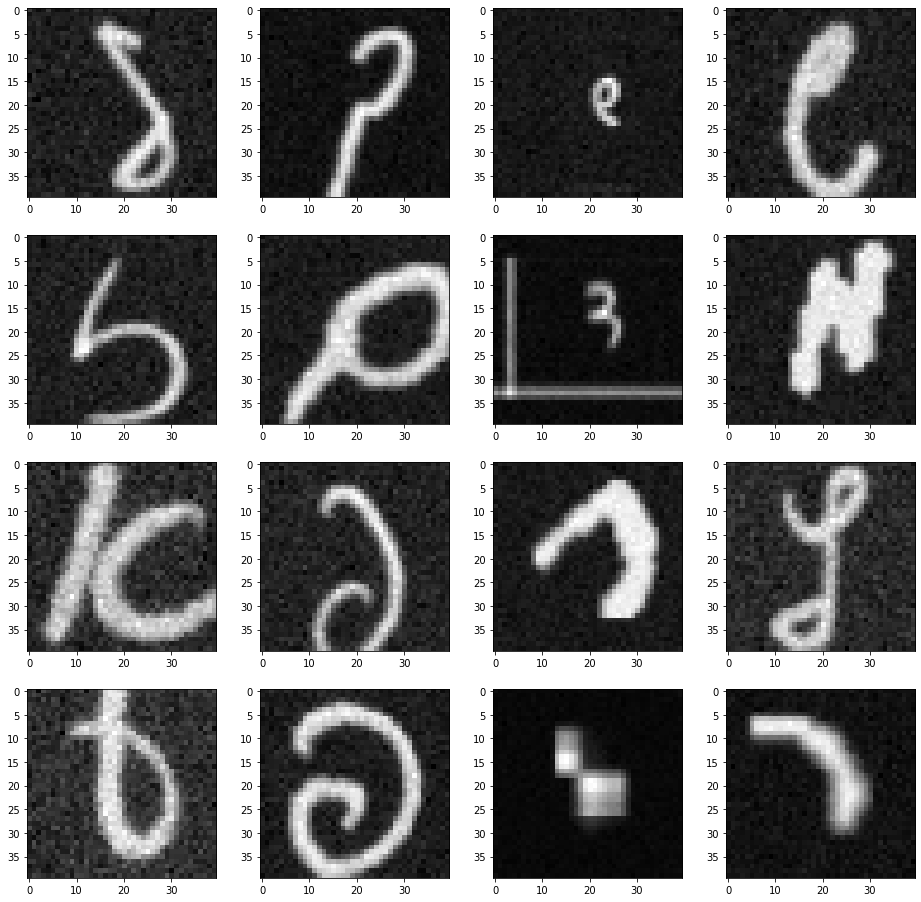

Found 6898 images belonging to 27 classes.
(40, 40, 1)
(40, 40, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, 
                                   height_shift_range=0.1, zoom_range=0.1,
                                   preprocessing_function = add_noise, shear_range=0.05,
                                   cval=0.1 ,brightness_range=[0.6,1.2])
val_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, 
                                   height_shift_range=0.1, zoom_range=0.1,
                                   preprocessing_function = add_noise, shear_range=0.05,
                                   cval=0.1 ,brightness_range=[0.6,1.2])

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(40,40),
        batch_size=1,
        color_mode = 'grayscale',
        class_mode='categorical'
        )

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(40,40),
        color_mode = 'grayscale',
        batch_size=64,
        class_mode='categorical'
        )

#Plots our figures
plt.figure(figsize=(16, 16))
for i in range(1,17):
  plt.subplot(4, 4, i)
  img= train_generator.next()
  plt.imshow(np.squeeze(img[0]), cmap= 'gray')
plt.show()

train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(40,40),
        batch_size=64,
        color_mode = 'grayscale',
        class_mode='categorical'
        )

print(train_generator.image_shape)
print(validation_generator.image_shape)

In [ ]:
import keras
import sys
from keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD,Adamax
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D

In [ ]:

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(40,40,1), activation = 'relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.6))
model.add(Dense(128, activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(27, activation ='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 40, 40, 64)        640       
                                                                 
 conv2d_19 (Conv2D)          (None, 40, 40, 32)        18464     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 20, 20, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                 

In [ ]:
opt = Adam(learning_rate=0.00009)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])

In [ ]:
from keras.callbacks import ModelCheckpoint
mc_acc = ModelCheckpoint('best_model_acc.h5', monitor='val_acc',initial_value_threshold =0.955, 
                     mode='max', verbose=1, save_best_only=True,)
mc_loss = ModelCheckpoint('best_model_loss.h5', monitor='val_loss',initial_value_threshold =0.159, 
                     mode='min', verbose=1, save_best_only=True,)

In [ ]:
model.load_weights('best_model 8.h5')

In [ ]:
history = model.fit(
      train_generator,
      epochs= 55,
      validation_data= validation_generator,
      verbose=2,
      callbacks = [mc_acc, mc_loss],
      shuffle=True,
      )

Epoch 1/55

Epoch 1: val_acc did not improve from 0.95500

Epoch 1: val_loss did not improve from 0.15900
108/108 - 5s - loss: 0.1171 - acc: 0.9575 - val_loss: 0.2061 - val_acc: 0.9373 - 5s/epoch - 49ms/step
Epoch 2/55

Epoch 2: val_acc did not improve from 0.95500

Epoch 2: val_loss did not improve from 0.15900
108/108 - 5s - loss: 0.1139 - acc: 0.9582 - val_loss: 0.1855 - val_acc: 0.9384 - 5s/epoch - 48ms/step
Epoch 3/55

Epoch 3: val_acc did not improve from 0.95500

Epoch 3: val_loss did not improve from 0.15900
108/108 - 5s - loss: 0.1111 - acc: 0.9585 - val_loss: 0.1971 - val_acc: 0.9384 - 5s/epoch - 48ms/step
Epoch 4/55

Epoch 4: val_acc did not improve from 0.95500

Epoch 4: val_loss did not improve from 0.15900
108/108 - 5s - loss: 0.1073 - acc: 0.9603 - val_loss: 0.1945 - val_acc: 0.9408 - 5s/epoch - 48ms/step
Epoch 5/55

Epoch 5: val_acc did not improve from 0.95500

Epoch 5: val_loss did not improve from 0.15900
108/108 - 5s - loss: 0.1105 - acc: 0.9580 - val_loss: 0.1918 -

In [ ]:
base_root = 'best_model '
end_file = '.h5'
for i in range(1,10):
  model_name = base_root + str(i) + end_file
  model.load_weights(model_name)
  print("evaluate model " + str(i))
  model.evaluate(validation_generator)

evaluate model 1
14/14 [==============================] - 1s 60ms/step - loss: 0.2886 - acc: 0.9152
evaluate model 2
14/14 [==============================] - 1s 58ms/step - loss: 0.2628 - acc: 0.9141
evaluate model 3
14/14 [==============================] - 1s 57ms/step - loss: 0.2916 - acc: 0.9129
evaluate model 4
14/14 [==============================] - 1s 60ms/step - loss: 0.2720 - acc: 0.9210
evaluate model 5
14/14 [==============================] - 1s 58ms/step - loss: 0.3609 - acc: 0.8920
evaluate model 6
14/14 [==============================] - 1s 59ms/step - loss: 0.2664 - acc: 0.9233
evaluate model 7
14/14 [==============================] - 1s 57ms/step - loss: 0.2650 - acc: 0.9152
evaluate model 8
14/14 [==============================] - 1s 57ms/step - loss: 0.2683 - acc: 0.9292
evaluate model 9
14/14 [==============================] - 1s 57ms/step - loss: 0.3379 - acc: 0.9094


In [ ]:
model.load_weights('best_model.h5')
model.evaluate(validation_generator)

13/13 [==============================] - 0s 21ms/step - loss: 0.1790 - acc: 0.9532


[0.1789545714855194, 0.953201949596405]

In [ ]:
def load_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(40,40,1), activation = 'relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation ='relu'))
    model.add(Dense(27, activation ='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["acc"])

    return model
model1 = load_model()
model2 = load_model()
model3 = load_model()
model4 = load_model()
model5 = load_model()

model1.load_weights('/content/best_model 1.h5')
model2.load_weights('/content/best_model 2.h5')
model3.load_weights('/content/best_model 3.h5')
model4.load_weights('/content/best_model 4.h5')
model5.load_weights('/content/best_model 5.h5')

In [ ]:
model5.evaluate(validation_generator)

13/13 [==============================] - 1s 19ms/step - loss: 0.1790 - acc: 0.9532


[0.17895452678203583, 0.953201949596405]

## Evaluate the trained model

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   img = Image.open(filename)
   np_image = np.array(img).astype('float32')/255
   np_image = transform.resize(np_image, (32, 32,1))
   np_image = (np.expand_dims(np_image, 0))
   return np_image

In [ ]:
import collections
my_dict = train_generator.class_indices
inv_map = {v: k for k, v in my_dict.items()}
inv_map

{0: 'alef',
 1: 'ayin',
 2: 'beit',
 3: 'chadic',
 4: 'chadic sofit',
 5: 'chaf',
 6: 'chaf sofit',
 7: 'chet',
 8: 'dalet',
 9: 'gimel',
 10: 'hai',
 11: 'koof',
 12: 'lamed',
 13: 'mem',
 14: 'mem sofit',
 15: 'noon',
 16: 'noon sofit',
 17: 'phei',
 18: 'phei sofit',
 19: 'rashe',
 20: 'samech',
 21: 'sheen',
 22: 'taf',
 23: 'tet',
 24: 'vav',
 25: 'yood',
 26: 'zain'}

In [ ]:
letter_hai = '/content/letter hai.png'
letter_vav = '/content/letter vav.png'
letter_zain = '/content/letter zain.png'
letter_dalet = '/content/letter dalet.png'
letter_beit = '/content/letter beit.png'

In [ ]:
for i in [letter_hai, letter_vav, letter_zain, letter_dalet, letter_beit]:
  pre_process_per_image(i)

In [ ]:
for i in [letter_hai, letter_vav, letter_zain, letter_dalet, letter_beit]:
    image = load(i)
    prediction = model(image)
    print(inv_map[np.argmax(prediction[0])] + ": " + str(np.max(prediction[0])))

hai: 0.96768683
vav: 0.96179324
zain: 0.58224696
chadic: 0.5955921
beit: 0.71255153


In [ ]:
model.load_weights('best_model.h5')